<a href="https://colab.research.google.com/github/RylieWeaver/NonParametric-Stats/blob/main/NonParametric_Final_Assignment_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonparametric Final

## 1. Setup

### Load Data

In [ ]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# Travel to Non-Parmetric stats directory
%cd "/content/drive/MyDrive/CGU/Non-Parametric Stats/Data"

/content/drive/MyDrive/CGU/Non-Parametric Stats/Data


In [ ]:
%ls

hormone.txt  law_data.txt


In [ ]:
# General imports
import pandas as pd
import numpy as np

In [ ]:
# Read file and name columns
data = pd.read_csv('hormone.txt', header=None)  # Even though it's a .txt, the data is separated by commas
data.columns = ['Lot', 'Hours_Worn', 'Hormone_Level']  # Make column names

# Make 1-hot encoding of lots
lot_dummies = pd.get_dummies(data['Lot'], prefix='Lot')
data = pd.concat([lot_dummies, data[['Hours_Worn', 'Hormone_Level']]], axis=1)
data[lot_dummies.columns] = lot_dummies.astype(int)  # Make true/falses as 1s / 0s

# Show
print(data.head(27))

    Lot_1  Lot_2  Lot_3  Hours_Worn  Hormone_Level
0       1      0      0          99           25.8
1       1      0      0         152           20.5
2       1      0      0         293           14.3
3       1      0      0         155           23.2
4       1      0      0         196           20.6
5       1      0      0          53           31.1
6       1      0      0         184           20.9
7       1      0      0         171           20.9
8       1      0      0          52           30.4
9       0      1      0         376           16.3
10      0      1      0         385           11.6
11      0      1      0         402           11.8
12      0      1      0          29           32.5
13      0      1      0          76           32.0
14      0      1      0         296           18.0
15      0      1      0         151           24.1
16      0      1      0         177           26.5
17      0      1      0         209           25.8
18      0      0      1        

## 2. Plot

In [ ]:
import matplotlib.pyplot as plt

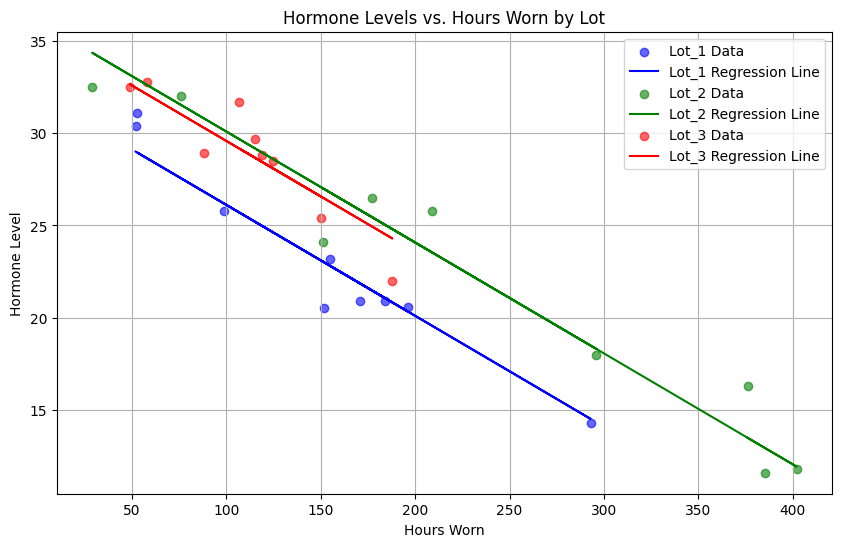

                            OLS Regression Results                            
Dep. Variable:          Hormone_Level   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     131.8
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.25e-14
Time:                        06:28:56   Log-Likelihood:                -48.926
No. Observations:                  27   AIC:                             105.9
Df Residuals:                      23   BIC:                             111.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Lot_1         32.1316      0.748     42.941      0.0

In [ ]:
# Data and Target
X = data[['Lot_1', 'Lot_2', 'Lot_3', 'Hours_Worn']]  # No add_constant here because the lots are the intercepts
y = data['Hormone_Level']

# Fit the OLS model (no added intercept)
model = sm.OLS(y, X).fit()

# Predictions for plotting
data['Predicted'] = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i, lot in enumerate(['Lot_1', 'Lot_2', 'Lot_3'], start=1):
    subset = data[data[lot] == 1]
    plt.scatter(subset['Hours_Worn'], subset['Hormone_Level'], color=colors[i-1], alpha=0.6, label=f'{lot} Data')
    plt.plot(subset['Hours_Worn'], subset['Predicted'], color=colors[i-1], label=f'{lot} Regression Line')
plt.title('Hormone Levels vs. Hours Worn by Lot')
plt.xlabel('Hours Worn')
plt.ylabel('Hormone Level')
plt.legend()
plt.grid(True)
plt.show()

# Print the model summary
print(model.summary())

In [ ]:
# Check beta with classic computation
beta = np.linalg.inv(X.T @ X) @ X.T @ y
print(beta)

# Same!

0    32.131595
1    36.105095
2    35.597324
3    -0.060136
dtype: float64


## 3. Confidence Bounds

In [ ]:
from scipy.stats import t as t_distn
import statsmodels as sm

### Normal Theory

In [ ]:
"""Estimate Variance unbiasedly"""

# Get n and p
n = X.shape[0]
p = X.shape[1]

# Compute middle matrix
XtX = np.dot(X.T, X)
XtX_inv = np.linalg.inv(XtX)
H = np.dot(np.dot(X, XtX_inv), X.T)
I = np.eye(n)  # Identity matrix
M = I - H

# Compute residual sum of squares
result = np.dot(np.dot(y.T, M), y)

# Unbiased estimate of variance
sigma_squared = result/(n-p)
print(f"n={n} | p={p}")
print("Unbiased Estimate of Variance (sigma^2):", sigma_squared)

# These are the same up to floating point errors

n=27 | p=4
Unbiased Estimate of Variance (sigma^2): 2.5769953129655416


In [ ]:
# Get n and p
n = X.shape[0]
p = X.shape[1]
dof = n-p

# Compute standard error
XtX = np.dot(X.T, X)
XtX_inv = np.linalg.inv(XtX)
t = np.array([1, -1, 0, 0])
std = np.sqrt(sigma_squared * np.dot(np.dot(t.T, XtX_inv), t))
print("Standard Error:", std)

# Compute estimate
estimate = np.dot(t, beta)
print("Estimate:", estimate)

# Compute crit values
alpha = 0.025
lower_bound = estimate - t_distn.ppf(1 - alpha, df=dof) * std
upper_bound = estimate - t_distn.ppf(alpha, df=dof) * std
print("Confidence Interval:", (lower_bound, upper_bound))

Standard Error: 0.8096861854115562
Estimate: -3.9734996690216136
Confidence Interval: (-5.648463158524391, -2.298536179518835)


Let's make this into a function and do all contrasts...

In [ ]:
def normal_contrast_confidence_bounds(contrasts, X, y, alpha=0.025):
    # Initialize returned confidence intervals
    confidence_intervals = []

    # Number of observations and parameters (to get degrees of freedom)
    n, p = X.shape
    dof = n - p
    # print(f"n={n} | p={p}")

    # Compute beta
    XtX = np.dot(X.T, X)
    XtX_inv = np.linalg.inv(XtX)
    beta = np.dot(XtX_inv, np.dot(X.T, y))
    # print("Beta:", beta)

    # Compute residuals
    y_hat = np.dot(X, beta)
    residuals = y - y_hat

    # Estimate unbiased variance with residuals
    RSS = np.dot(residuals.T, residuals)
    sigma_squared = RSS / dof
    # print("Unbiased Estimate of Variance (sigma^2):", sigma_squared)

    # Get t-values
    t_lo = t_distn.ppf(alpha, df=dof)  # Lower critical t-value
    t_up = t_distn.ppf(1 - alpha, df=dof)  # Upper critical t-value

    # Iterate over all contrasts
    for t in contrasts:
        # Make sure it's an array
        t = np.array(t)
        print(f"Contrast: {t}")  # Show

        # Compute std error
        std = np.sqrt(sigma_squared * np.dot(np.dot(t.T, XtX_inv), t))

        # Compute the contrast estimate
        estimate = np.dot(t, beta)
        print("Estimate:", estimate)

        # Compute the confidence interval
        lower_bound = estimate - t_up * std
        upper_bound = estimate - t_lo * std

        print("Confidence Interval:", (lower_bound, upper_bound))
        print()

        # Append the confidence interval to the list
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

In [ ]:
# Test the function
contrasts = [[1, -1, 0, 0]]  # Lot_2 - Lot_1
confidence_intervals = normal_contrast_confidence_bounds(contrasts, X, y)
print("Confidence Intervals:")
print(confidence_intervals[0])

Contrast: [ 1 -1  0  0]
Estimate: -3.9734996690216278
Confidence Interval: (-5.648463158524435, -2.2985361795188206)

Confidence Intervals:
(-5.648463158524435, -2.2985361795188206)


In [ ]:
# Make intervals
contrasts = [[1, -1, 0, 0], [1, 0, -1, 0], [0, 1, -1, 0]]
normal_confidence_intervals = normal_contrast_confidence_bounds(contrasts, X, y)

# Show
print("Normal Confidence Intervals:")
for confidence_interval in normal_confidence_intervals:
    print(confidence_interval)

Contrast: [ 1 -1  0  0]
Estimate: -3.9734996690216278
Confidence Interval: (-5.648463158524435, -2.2985361795188206)

Contrast: [ 1  0 -1  0]
Estimate: -3.4657293804668328
Confidence Interval: (-5.056781912913565, -1.8746768480201002)

Contrast: [ 0  1 -1  0]
Estimate: 0.507770288554795
Confidence Interval: (-1.288061860483236, 2.3036024375928266)

Normal Confidence Intervals:
(-5.648463158524435, -2.2985361795188206)
(-5.056781912913565, -1.8746768480201002)
(-1.288061860483236, 2.3036024375928266)


### Bootstrap

In [ ]:
# Testing
residuals = y - np.dot(X, beta)
residuals_centered = residuals - np.mean(residuals)
# print(residuals)
# print(residuals_centered)
print(np.mean(residuals))
print(np.mean(residuals_centered))

-5.131697536045168e-15
5.756711979537848e-17


In [ ]:
# Easier to make a function to bootstrap one at a time and call multiple times

def bootstrap_contrast_confidence_bound(t, X, y, B=10000, alpha=0.025):
    n, p = X.shape
    dof = n - p

    # Compute beta and residuals
    XtX = np.dot(X.T, X)
    XtX_inv = np.linalg.inv(XtX)
    beta = np.dot(XtX_inv, np.dot(X.T, y))
    residuals = y - np.dot(X, beta)
    residuals_centered = residuals - np.mean(residuals)  # Center

    # Ensure t is a numpy array
    t = np.array(t)

    # Initialize array to store bootstrap pivot values
    P = np.zeros(B)

    for i in range(B):
        # Bootstrap residuals
        epsilon_star = np.random.choice(residuals_centered, size=n, replace=True)

        # Compute bootstrap Y
        Y_star = np.dot(X, beta) + epsilon_star

        # Compute bootstrap beta
        beta_star = np.dot(XtX_inv, np.dot(X.T, Y_star))

        # Compute residuals and variance for Y_star
        residuals_star = Y_star - np.dot(X, beta_star)
        RSS_star = np.dot(residuals_star.T, residuals_star)
        sigma_squared_star = RSS_star / dof

        # Compute the pivot
        std = np.sqrt(sigma_squared_star * np.dot(t.T, np.dot(XtX_inv, t)))
        pivot = (np.dot(t, beta_star) - np.dot(t, beta)) / std

        # Store pivot value
        P[i] = pivot

    # Calculate bootstrap confidence intervals
    P_sorted = np.sort(P)
    lower_bound = np.percentile(P_sorted, alpha*100)
    upper_bound = np.percentile(P_sorted, (1-alpha)*100)

    # Calculate the estimate using the original beta
    estimate = np.dot(t, beta)
    confidence_interval = (estimate + lower_bound * std, estimate + upper_bound * std)

    # Show
    print(f"Contrast: {t}")
    print("Estimate:", estimate)
    print("Bootstrap Confidence Interval:", confidence_interval)
    print()

    return confidence_interval

In [ ]:
# Make intervals
bootstrap_confidence_intervals = []
contrasts = [[1, -1, 0, 0], [1, 0, -1, 0], [0, 1, -1, 0]]
for contrast in contrasts:
    bootstrap_confidence_interval = bootstrap_contrast_confidence_bound(contrast, X, y, B=100000)
    bootstrap_confidence_intervals.append(bootstrap_confidence_interval)

# Show
print("Bootstrap Confidence Intervals:")
for confidence_interval in bootstrap_confidence_intervals:
    print(confidence_interval)

Contrast: [ 1 -1  0  0]
Estimate: -3.9734996690216278
Bootstrap Confidence Interval: (-5.52593873991632, -2.42169241503296)

Contrast: [ 1  0 -1  0]
Estimate: -3.4657293804668328
Bootstrap Confidence Interval: (-5.006935577320595, -1.9523798629655786)

Contrast: [ 0  1 -1  0]
Estimate: 0.507770288554795
Bootstrap Confidence Interval: (-1.0894621223568635, 2.100447879505954)

Bootstrap Confidence Intervals:
(-5.52593873991632, -2.42169241503296)
(-5.006935577320595, -1.9523798629655786)
(-1.0894621223568635, 2.100447879505954)


## Analysis

To re-iterate, we have:

**Normal Confidence Intervals:**

Contrast: [ 1 -1  0  0]
Estimate: -3.9734996690216278
Confidence Interval: (-5.648463158524435, -2.2985361795188206)

Contrast: [ 1  0 -1  0]
Estimate: -3.4657293804668328
Confidence Interval: (-5.056781912913565, -1.8746768480201002)

Contrast: [ 0  1 -1  0]
Estimate: 0.507770288554795
Confidence Interval: (-1.288061860483236, 2.3036024375928266)


**Bootstrap Confidence Intervals:**

Contrast: [ 1 -1  0  0]
Estimate: -3.9734996690216278
Bootstrap Confidence Interval: (-5.52593873991632, -2.42169241503296)

Contrast: [ 1  0 -1  0]
Estimate: -3.4657293804668328
Bootstrap Confidence Interval: (-5.006935577320595, -1.9523798629655786)

Contrast: [ 0  1 -1  0]
Estimate: 0.507770288554795
Bootstrap Confidence Interval: (-1.0894621223568635, 2.100447879505954)

---

We see that the bootstrap confidence intervals are similar to normal-theory confidence intervals, with there being slight differences from around 0.05 to 0.20 on each side.

In addition, we see that the first two confidence intervals do not contain 0 in both interval types, indicating that the intercepts for Lot 2 and Lot 3 are greater than the intercept for Lot 1. On the other hand, the difference between intercepts of Lot 2 and Lot 3 do contain 0 in both interval types, meaning that we can not significantly conclude a difference in intercept between Lot 2 and Lot 3.

Overall, our conclusion would be the Β1 < B2, B3.